# Import Library : 분석에 사용할 모듈 설치

"통계추론, 기계학습 및 딥러닝의 흐름에 시간패턴을 반영하려 진화"

"지도학습(예측 분류), 비지도학습 문제에 모두 활용되는 필수 알고리즘"

"미래 예측을 포함한 추천 서비스와 같은 비즈니스에 활용중"

<img src='./img/TS_Evolution.png'>

In [8]:
# !pip install --upgrade pip
# !python -m pip install --user --upgrade pip
# !pip install pandas-datareader
# !pip install tqdm
# !pip install xgboost
# !pip install lightgbm
# !pip install --user pmdarima

In [19]:
# Auto reload and user defined functions
%reload_ext autoreload
%autoreload 2
from module_regression import *
from module_classification import *
from module_timeseries import *

# Data manipulation and useful functions
import requests
from io import BytesIO
import random
from itertools import product
import scipy as sp

# Time series algorithms
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import AutoARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

# **Base Algorithm:** Linear Regression

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


DateTime
2011-01-01 00:00:00    41.04
2011-01-01 01:00:00    41.04
2011-01-01 02:00:00    41.04
2011-01-01 03:00:00    41.04
2011-01-01 04:00:00    41.04
                       ...  
2012-06-30 19:00:00   233.88
2012-06-30 20:00:00   233.21
2012-06-30 21:00:00   232.25
2012-06-30 22:00:00   232.62
2012-06-30 23:00:00   236.96
Freq: H, Name: count_Day, Length: 13128, dtype: float64

Number_of_Total_X:  24
Number_of_Selected_X:  12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              6925.
Date:                Wed, 03 May 2023   Prob (F-statistic):                        0.00
Time:                        00:40:40   Log-Likelihood:                         -77008.
No. Observations:               13128   AIC:                                  1.540e+05
Df Residuals:                   13116   BIC:                                  1.541e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
count_diff       1289.2806     25.881     49.816      0.000    1238.550    1340.011
holiday          7.141e+04   1.01e+04      7.044      0.000    5.15e+04    9.13e+04
count_seasonal   1270.9307     16.107     78.906      0.000    1239.359    1302.503
Day              1151.2606    168.230      6.843      0.000     821.505    1481.017
windspeed        -234.1084    180.733     -1.295      0.195    -588.370     120.154
Quarter_ver2     2.865e+04    930.475     30.787      0.000    2.68e+04    3.05e+04
Hour            -3514.0425    282.316    -12.447      0.000   -4067.422   -2960.663
weather         -2.423e+04   2238.550    -10.825      0.000   -2.86e+04   -1.98e+04
Quarter_Dummt_2  6.725e+04   3436.993     19.566      0.000    6.05e+04     7.4e+04
DayofWeek        1.621e+04    912.387     17.768      0.000    1.44e+04     1.8e+04
workingday       7.695e+04   4056.717     18.970      0.000     6.9e+04    8.49e+04
count_lag2       1061.0008     14.379     73.788      0.000    1032.816    1089.186
==============================================================================
Omnibus:                     1665.324   Durbin-Watson:                   0.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5853.426
Skew:                           0.626   Prob(JB):                         0.00
Kurtosis:                       6.022   Cond. No.                     1.53e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

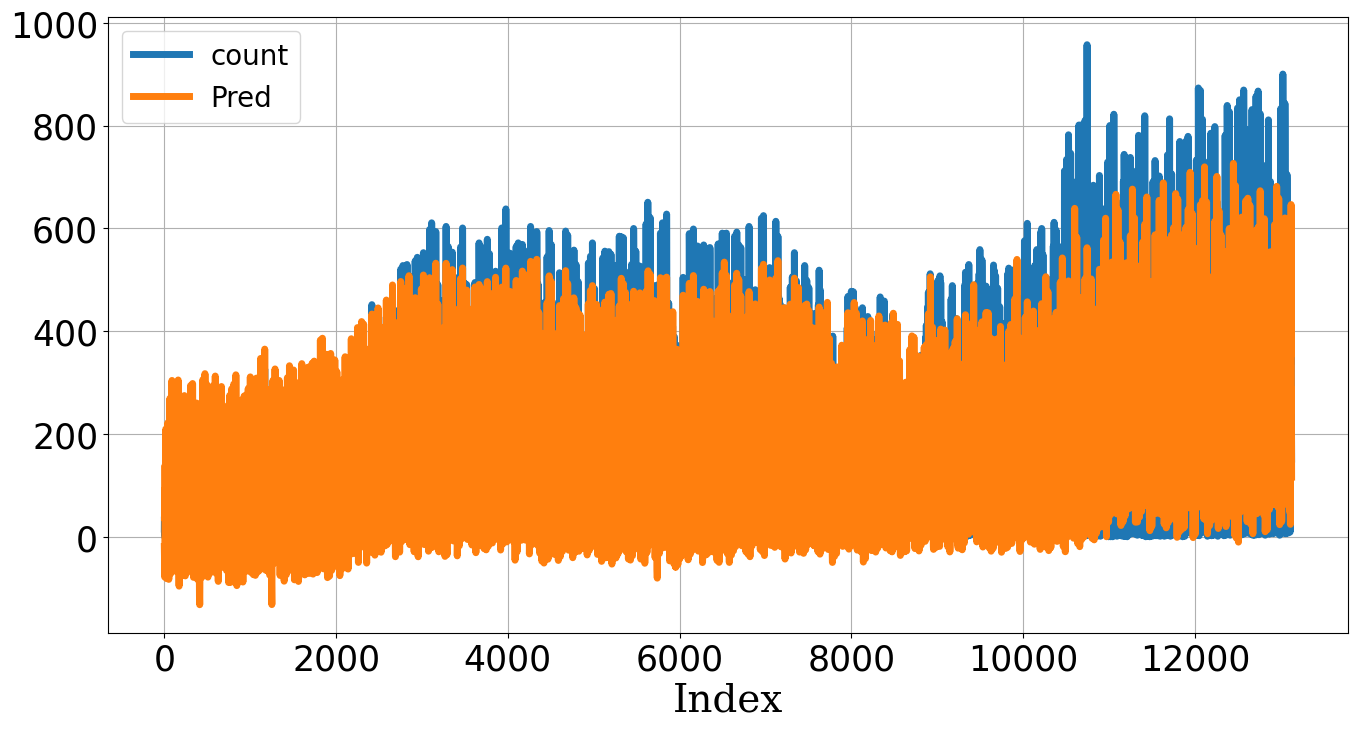

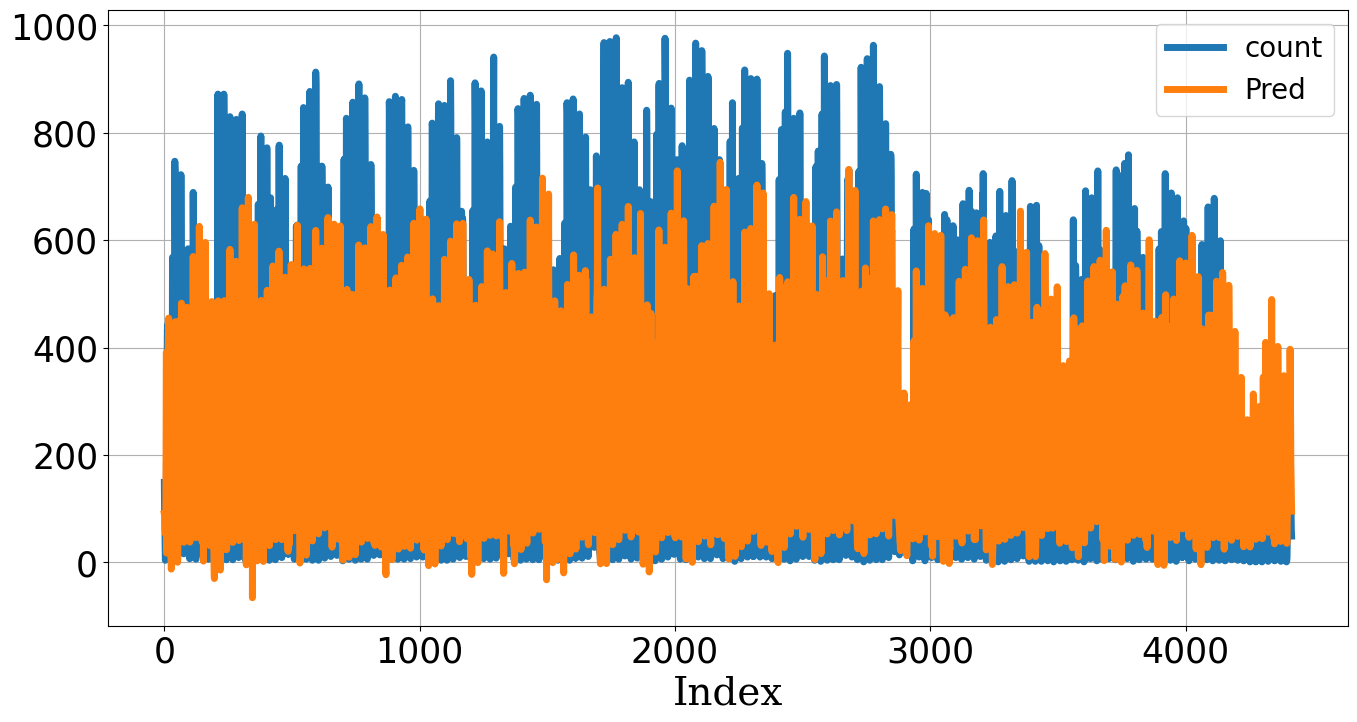

,MAE,MSE,MAPE
Train,60.84,"7,288.40",2.02
Test,99.87,"19,151.40",1.53


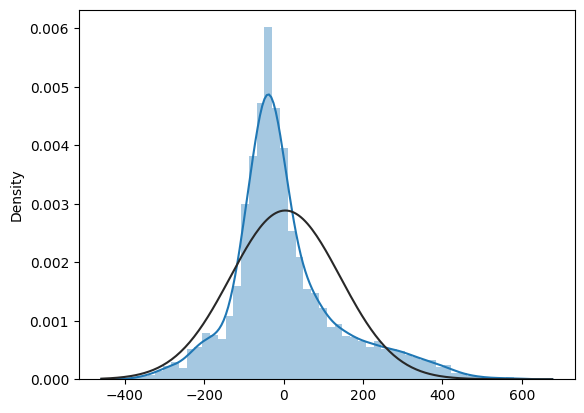

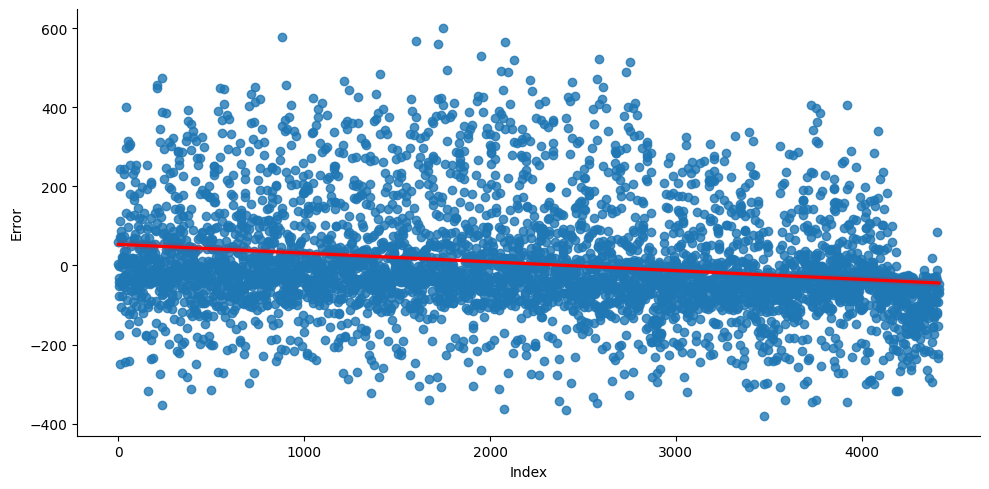

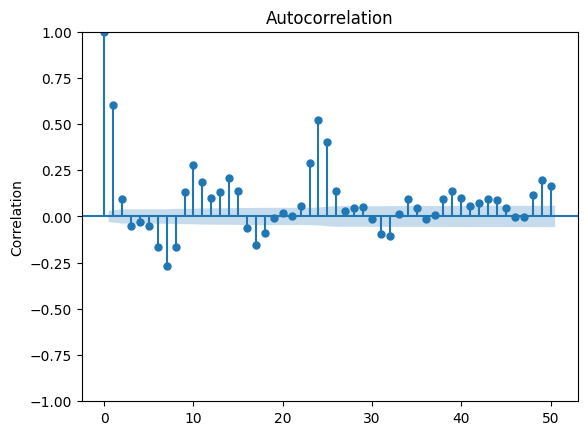

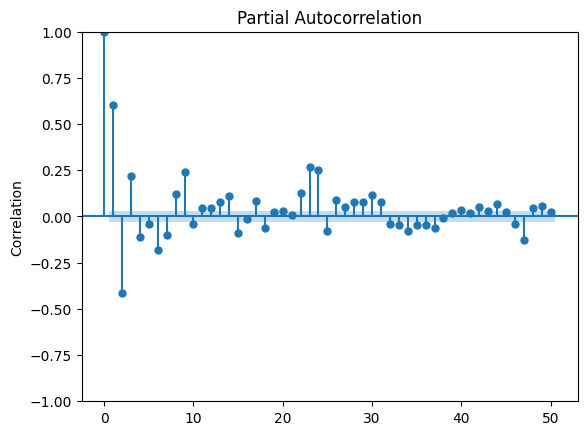

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.93,0.70,"2,631.01","6,552.71",-3.58,9.89
p-value,0.00,0.00,0.00,0.00,0.01,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,15.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [21]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
display(X_train['count_Day'])
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(), 
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# Linear Regression
model_lr = sm.OLS(Y_train, X_train_RSM).fit()
display(model_lr.summary())

Y_trpred = pd.DataFrame(model_lr.predict(X_train_RSM), columns=['Pred'])
Y_tepred = pd.DataFrame(model_lr.predict(X_test_RSM), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score)

# 에러 분석
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

# **Advanced Algorithm:** Random Forest

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


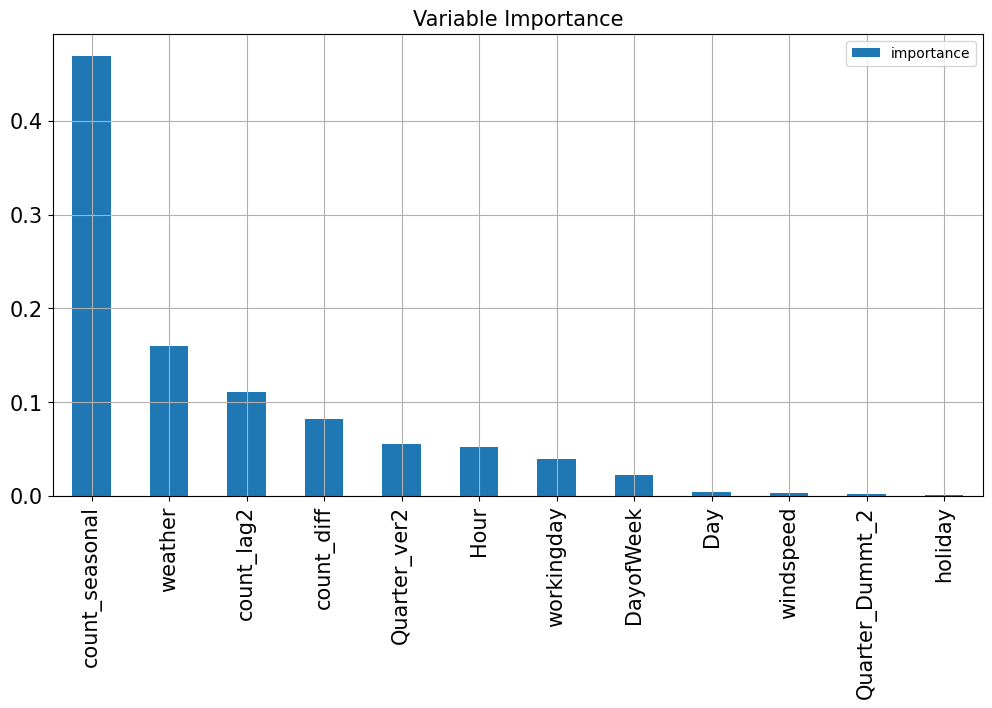

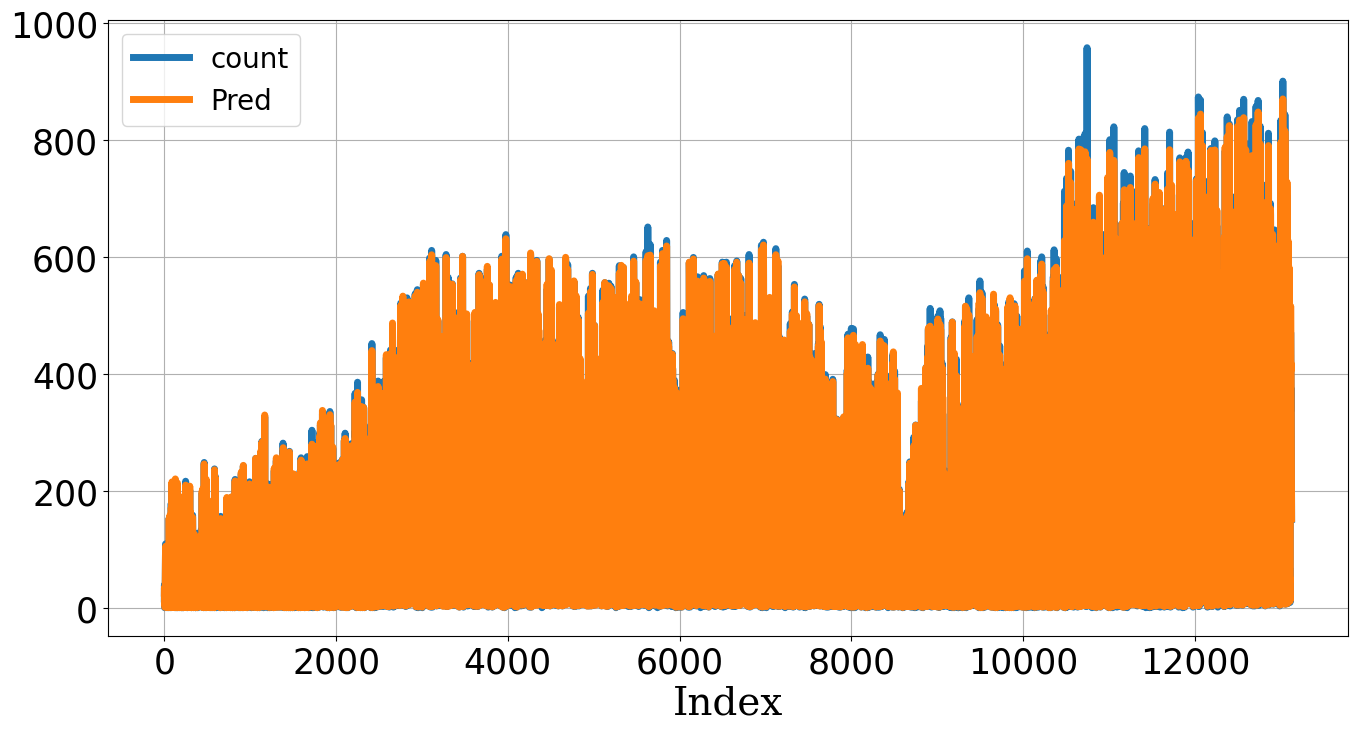

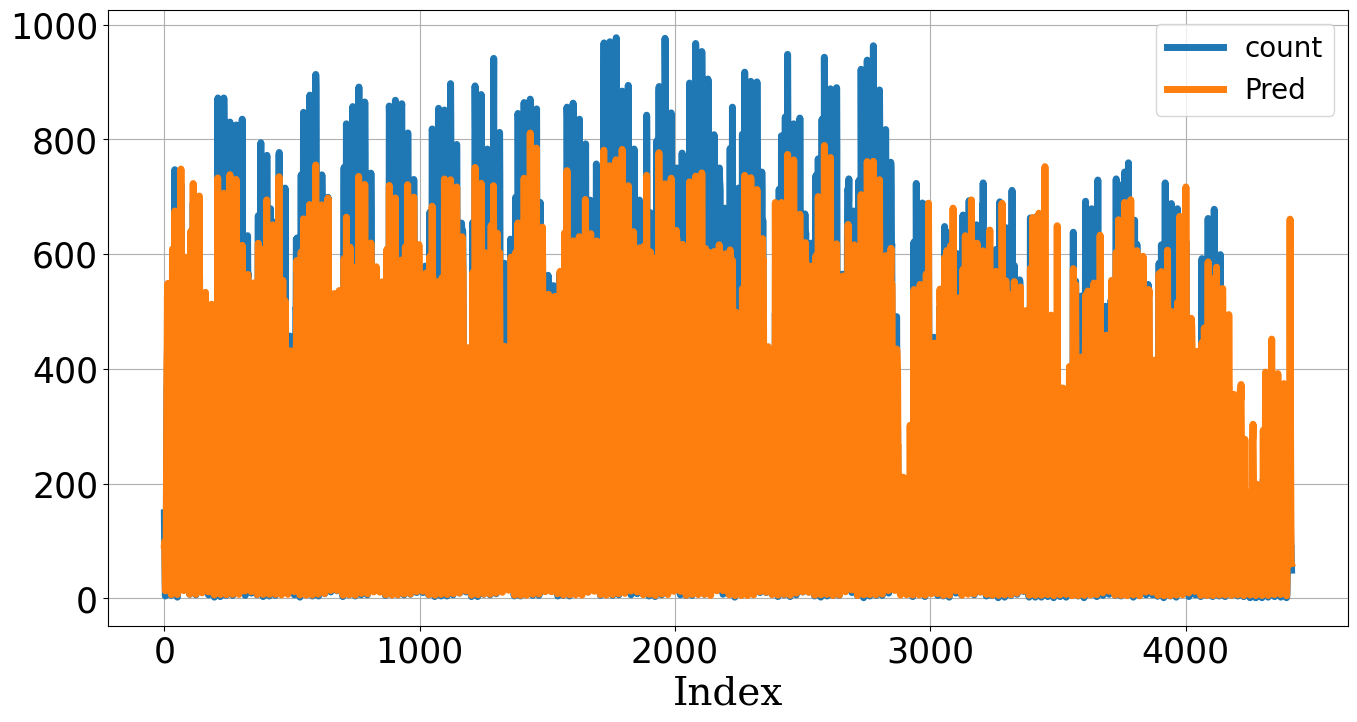

,MAE,MSE,MAPE
Train,6.54,123.38,0.09
Test,51.52,"6,749.92",0.40


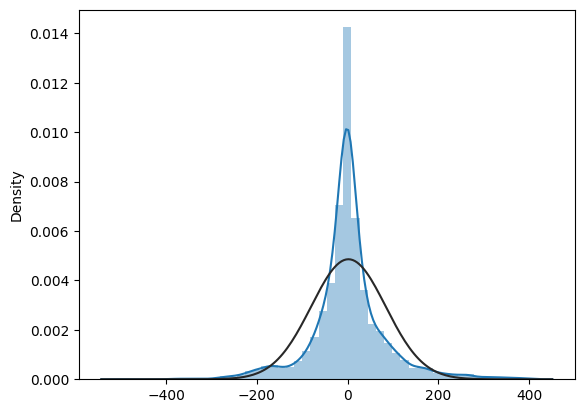

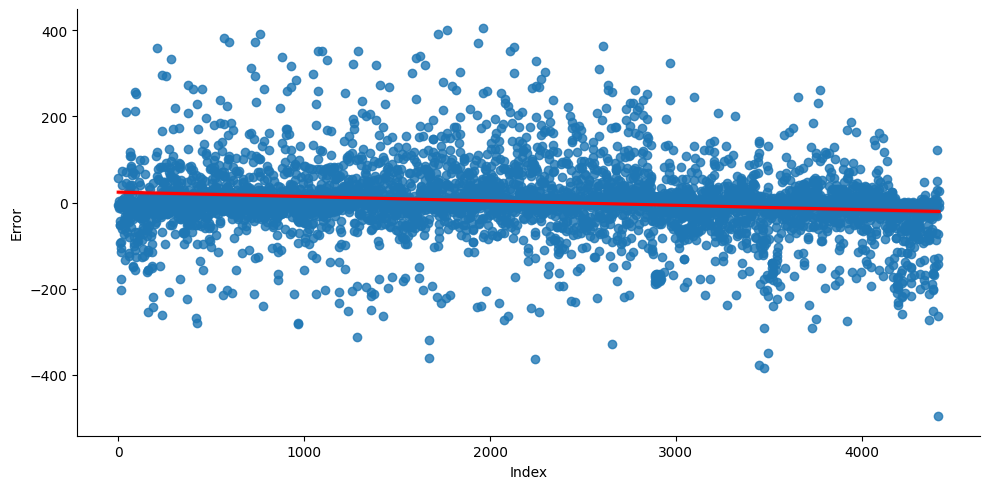

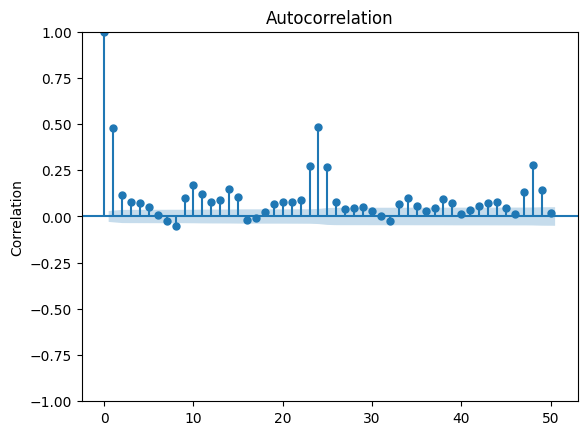

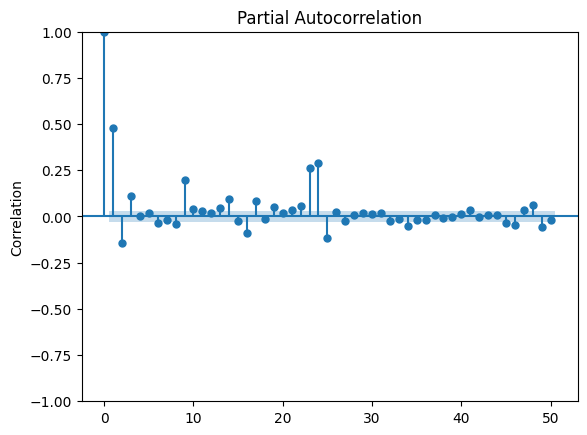

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.90,0.86,"1,337.93","4,231.86",-5.83,4.49
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,26.00,21.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [23]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(),
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, 
                                 random_state=123,
                                 n_jobs=-1)
model_rf.fit(X_train_RSM, Y_train)
# 변수 중요도
Variable_Importance = pd.DataFrame([model_rf.feature_importances_],
                                   columns=X_train_RSM.columns,
                                   index=['importance']).T.sort_values(by=['importance'], ascending=False)
Variable_Importance.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importance', fontsize=15)
plt.grid()
plt.show()

Y_trpred = pd.DataFrame(model_rf.predict(X_train_RSM),
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model_rf.predict(X_test_RSM),
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score)

# 에러 분석
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

# **Advanced Algorithm:** SARIMA

## 데이터 전처리

In [24]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(),
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


## 파라미터 추론

H0 of ADF:  비정상상태
H0 of KPSS:  정상상태


,Stationarity_ADF,Stationarity_KPSS
Test Statistics,-6.84,13.63
p-value,0.00,0.01
Used Lag,41.00,34.00
Critical Value (1%),-3.43,0.74
Critical Value (5%),-2.86,0.46
Critical Value (10%),-2.57,0.35
Critical Value (2.5%),NaN,0.57


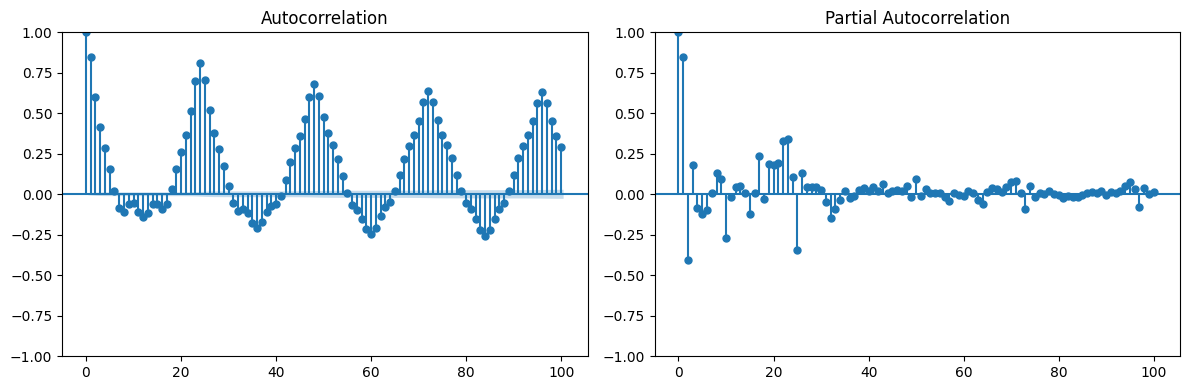

In [25]:
## 정상성 테스트 및 모수추론
print('H0 of ADF: ', '비정상상태')
print('H0 of KPSS: ', '정상상태')
display(stationarity_ADF_KPSS(pd.DataFrame(Y_train.values.flatten())))

plt.figure(figsize=(12,4))
plot_acf(Y_train, lags=100, alpha=0.5, use_vlines=True, ax=plt.subplot(121))
plot_pacf(Y_train, lags=100, alpha=0.5, use_vlines=True, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

In [ ]:
# p=2, d=0, q=5, P=2, D=1, Q=4, D(m)=24
# (시간상 p=1, d=0, q=1, P=1, D=0, Q=1, D(m)=24 로 일단 시작!)

## 정상성 미변환

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.61339D+00    |proj g|=  6.78714D-02


 This problem is unconstrained.



At iterate    5    f=  5.55892D+00    |proj g|=  4.47746D-02

At iterate   10    f=  5.53828D+00    |proj g|=  5.78359D-03

At iterate   15    f=  5.50877D+00    |proj g|=  1.29253D-01

At iterate   20    f=  5.46361D+00    |proj g|=  3.11555D-03

At iterate   25    f=  5.46351D+00    |proj g|=  7.92176D-03

At iterate   30    f=  5.45482D+00    |proj g|=  4.67745D-02

At iterate   35    f=  5.42796D+00    |proj g|=  8.90963D-02

At iterate   40    f=  5.39178D+00    |proj g|=  4.56271D-02

At iterate   45    f=  5.37377D+00    |proj g|=  3.45498D-03

At iterate   50    f=  5.37140D+00    |proj g|=  2.81529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

,MAE,MSE,MAPE
Train,33.93,"2,702.62",0.59
Test,96.45,"18,568.86",1.61


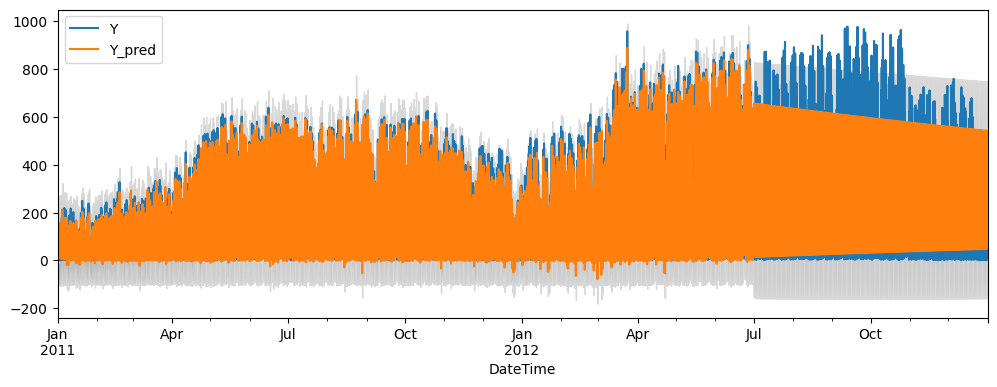

In [27]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(), 
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# 모델링
## Parameter Setting
TREND_ORDER = (1,0,1)
SEASONAL_ORDER = (1,0,1,24)
pred_start = Y_train.index[0]
pred_end = Y_test.index[-1]
## SARIMA
model_sarima = SARIMAX(Y_train, trend='c', 
                       order=TREND_ORDER, 
                       seasonal_order=SEASONAL_ORDER).fit()
display(model_sarima)
model_pred = model_sarima.get_prediction(start=pred_start, end=pred_end)
Y_pred = model_pred.predicted_mean
Y_pred_ci = model_pred.conf_int()
    
# 검증
Y_trindex = [i for i in Y_pred.index if i in Y_train.index]
Y_teindex = [i for i in Y_pred.index if i in Y_test.index]
Y_trpred = pd.DataFrame(Y_pred).loc[Y_trindex]
Y_tepred = pd.DataFrame(Y_pred).loc[Y_teindex]
Score_sarima = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_sarima)

# 결과 시각화
ax = pd.DataFrame(pd.concat([Y_train, Y_test], axis=0)).plot(figsize=(12,4))
pd.DataFrame(Y_pred).plot(label='Time Sequence Prediction', ax=ax)
ax.fill_between(Y_pred_ci.index, Y_pred_ci.iloc[:,0], Y_pred_ci.iloc[:,1], 
                color='k', alpha=0.15)
plt.legend(['Y', 'Y_pred'])
plt.show()

## 정상성 변환 및 미복원

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58532D+00    |proj g|=  2.85383D+00


 This problem is unconstrained.



At iterate    5    f=  7.59022D-01    |proj g|=  1.93880D-01

At iterate   10    f=  6.46389D-01    |proj g|=  1.76522D+00

At iterate   15    f=  6.13458D-01    |proj g|=  2.47240D-02

At iterate   20    f=  6.11249D-01    |proj g|=  2.90090D-01

At iterate   25    f=  6.09371D-01    |proj g|=  4.33427D-02

At iterate   30    f=  6.07656D-01    |proj g|=  1.38690D-01

At iterate   35    f=  5.98491D-01    |proj g|=  7.18654D-01

At iterate   40    f=  5.96007D-01    |proj g|=  1.44963D+00

At iterate   45    f=  5.95170D-01    |proj g|=  1.71860D-01

At iterate   50    f=  5.94804D-01    |proj g|=  4.48322D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

,MAE,MSE,MAPE
Train,0.30,0.19,"61,886,036,400,839.30"
Test,0.53,0.54,"24,910,549,638,196.02"


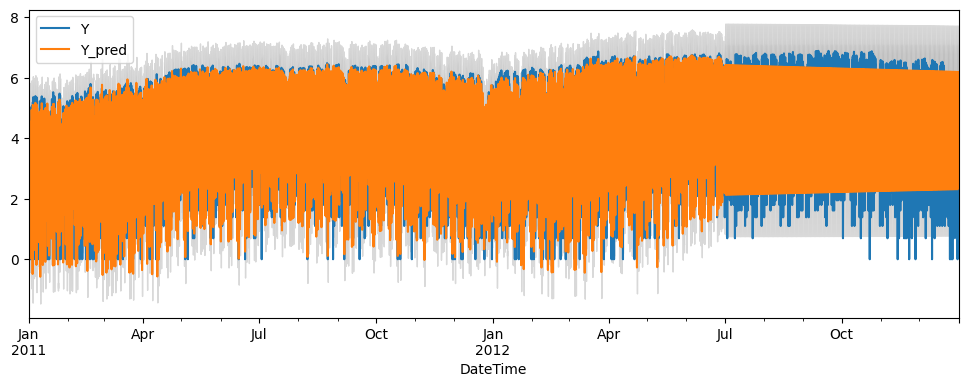

In [28]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(),
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# 모델링
## Parameter Setting
LOFARITHM = True
TREND_ORDER = (1,0,1)
SEASONAL_ORDER = (1,0,1,24)
pred_start = Y_train.index[0]
pred_end = Y_test.index[-1]
## 비정상 데이터의 정상성 변환
if LOFARITHM:
    Y_train = np.log(Y_train).copy()
    Y_test = np.log(Y_test).copy()
#########################
## SARIMA
model_sarima = SARIMAX(Y_train, trend='c',
                       order=TREND_ORDER,
                       seasonal_order=SEASONAL_ORDER).fit()
display(model_sarima)
model_pred = model_sarima.get_prediction(start=pred_start, end=pred_end)
Y_pred = model_pred.predicted_mean
Y_pred_ci = model_pred.conf_int()

# 검증
Y_trindex = [i for i in Y_pred.index if i in Y_train.index]
Y_teindex = [i for i in Y_pred.index if i in Y_test.index]
Y_trpred = pd.DataFrame(Y_pred).loc[Y_trindex]
Y_tepred = pd.DataFrame(Y_pred).loc[Y_teindex]
Score_sarima = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_sarima)

# 결과 시각화
ax = pd.DataFrame(pd.concat([Y_train, Y_test], axis=0)).plot(figsize=(12,4))
pd.DataFrame(Y_pred).plot(label='Time Sequence Prediction', ax=ax)
ax.fill_between(Y_pred_ci.index, Y_pred_ci.iloc[:,0], Y_pred_ci.iloc[:,1],
                color='k', alpha=0.15)
plt.legend(['Y', 'Y_pred'])
plt.show()

## 정상성 변환 및 복원

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58532D+00    |proj g|=  2.85383D+00

At iterate    5    f=  7.59022D-01    |proj g|=  1.93880D-01

At iterate   10    f=  6.46389D-01    |proj g|=  1.76522D+00

At iterate   15    f=  6.13458D-01    |proj g|=  2.47240D-02

At iterate   20    f=  6.11249D-01    |proj g|=  2.90090D-01

At iterate   25    f=  6.09371D-01    |proj g|=  4.33427D-02

At iterate   30    f=  6.07656D-01    |proj g|=  1.38690D-01

At iterate   35    f=  5.98491D-01    |proj g|=  7.18654D-01

At iterate   40    f=  5.96007D-01    |proj g|=  1.44963D+00

At iterate   45    f=  5.95170D-01    |proj g|=  1.71860D-01

At iterate   50    f=  5.94804D-01    |proj g|=  4.48322D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

,MAE,MSE,MAPE
Train,30.78,"2,400.16",0.36
Test,94.43,"19,709.24",0.88


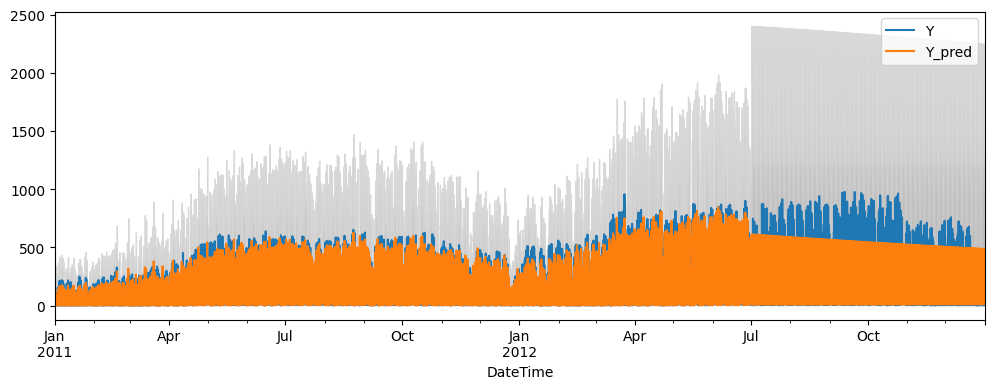

In [29]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(),
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# 모델링
## Parameter Setting
LOFARITHM = True
TREND_ORDER = (1,0,1)
SEASONAL_ORDER = (1,0,1,24)
pred_start = Y_train.index[0]
pred_end = Y_test.index[-1]
## 비정상 데이터의 정상성 변환
if LOFARITHM:
    Y_train = np.log(Y_train).copy()
    Y_test = np.log(Y_test).copy()
#########################
## SARIMA
model_sarima = SARIMAX(Y_train, trend='c',
                       order=TREND_ORDER,
                       seasonal_order=SEASONAL_ORDER).fit()
display(model_sarima)
model_pred = model_sarima.get_prediction(start=pred_start, end=pred_end)
Y_pred = model_pred.predicted_mean
Y_pred_ci = model_pred.conf_int()
## 정상성 데이터의 비정상성 변환
if LOFARITHM:
    Y_train = np.exp(Y_train).copy()
    Y_test = np.exp(Y_test).copy()
    Y_pred = np.exp(Y_pred).copy()
    Y_pred_ci = np.exp(Y_pred_ci).copy()
#########################

# 검증
Y_trindex = [i for i in Y_pred.index if i in Y_train.index]
Y_teindex = [i for i in Y_pred.index if i in Y_test.index]
Y_trpred = pd.DataFrame(Y_pred).loc[Y_trindex]
Y_tepred = pd.DataFrame(Y_pred).loc[Y_teindex]
Score_sarima = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_sarima)

# 결과 시각화
ax = pd.DataFrame(pd.concat([Y_train, Y_test], axis=0)).plot(figsize=(12,4))
pd.DataFrame(Y_pred).plot(label='Time Sequence Prediction', ax=ax)
ax.fill_between(Y_pred_ci.index, Y_pred_ci.iloc[:,0], Y_pred_ci.iloc[:,1],
                color='k', alpha=0.15)
plt.legend(['Y', 'Y_pred'])
plt.show()

# **Advanced Algorithm:** SARIMAX

## 독립변수 일부 반영

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14238D-01    |proj g|=  4.14807D-01

At iterate    5    f=  8.76389D-01    |proj g|=  8.61588D-02

At iterate   10    f=  7.78590D-01    |proj g|=  3.53646D-01

At iterate   15    f=  7.53464D-01    |proj g|=  4.17398D-01

At iterate   20    f=  7.42981D-01    |proj g|=  7.06554D+00

At iterate   25    f=  7.31773D-01    |proj g|=  9.45231D-02

At iterate   30    f=  7.31431D-01    |proj g|=  1.92257D+00

At iterate   35    f=  7.22197D-01    |proj g|=  7.72776D+00

At iterate   40    f=  7.18588D-01    |proj g|=  5.00824D-02

At iterate   45    f=  7.18573D-01    |proj g|=  2.81230D-02

At iterate   50    f=  7.18570D-01    |proj g|=  2.33745D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

,MAE,MSE,MAPE
Train,34.80,"3,639.51",0.39
Test,191.70,"94,256.72",1.65


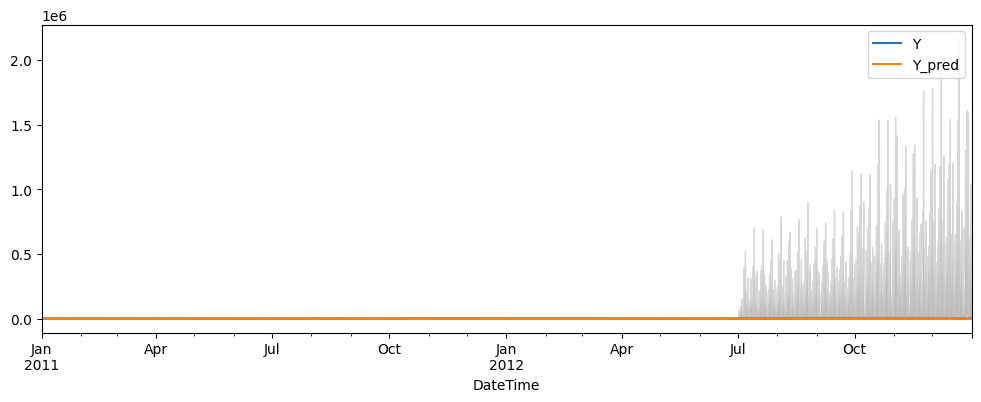

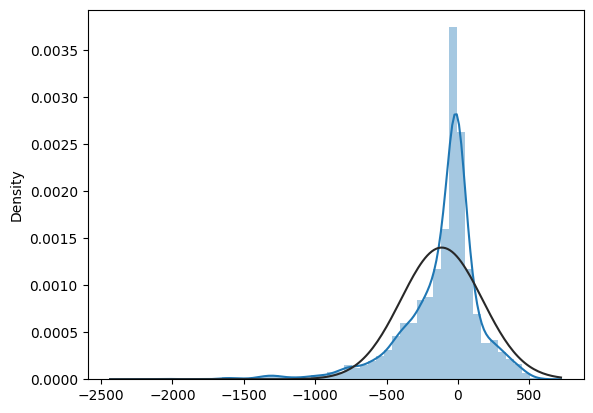

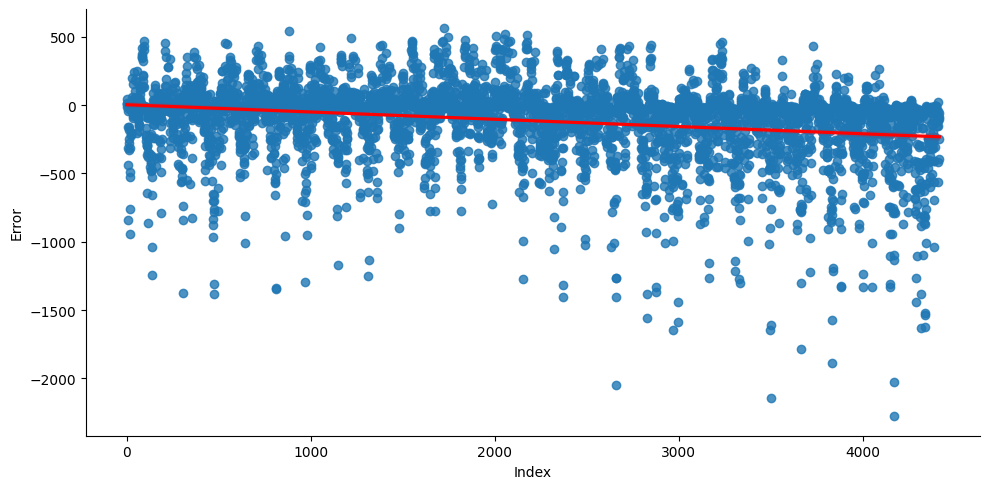

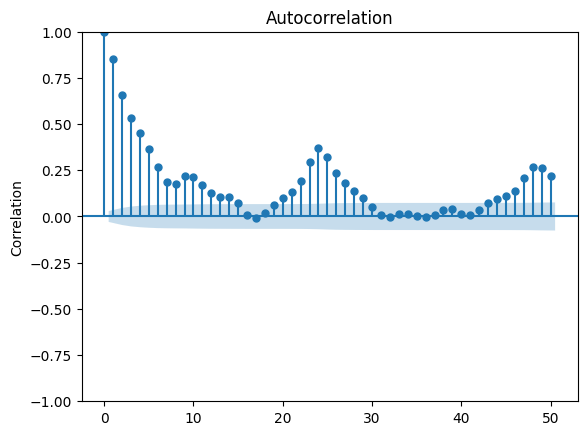

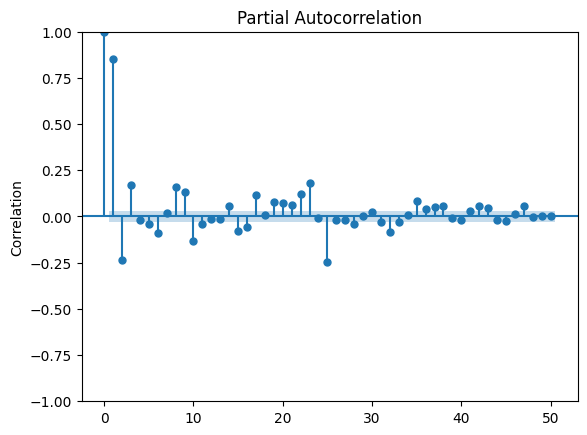

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.86,1.58,"8,871.80","12,724.96",-9.76,2.81
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,34.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [32]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(),
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# 모델링
## Additional Features
exog_tr = X_train_RSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quarter_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_RSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quarter_ver2', 'Hour', 'workingday', 'DayofWeek']]
## Parameter Setting
LOFARITHM = True
TREND_ORDER = (1,0,1)
SEASONAL_ORDER = (1,0,1,24)
pred_start = Y_train.index[0]
pred_end = Y_test.index[-1]
## 비정상 데이터의 정상성 변환
if LOFARITHM:
    Y_train = np.log(Y_train).copy()
    Y_test = np.log(Y_test).copy()
#########################
## SARIMAX
model_sarimax = SARIMAX(Y_train, exog=exog_tr, trend='c',
                        order=TREND_ORDER,
                        seasonal_order=SEASONAL_ORDER).fit()    # 독립변수 반영
display(model_sarimax)
model_pred = model_sarimax.get_prediction(start=pred_start, end=pred_end, exog=exog_te) # 독립변수 반영
Y_pred = model_pred.predicted_mean
Y_pred_ci = model_pred.conf_int()
## 정상성 데이터의 비정상성 변환
if LOFARITHM:
    Y_train = np.exp(Y_train).copy()
    Y_test = np.exp(Y_test).copy()
    Y_pred = np.exp(Y_pred).copy()
    Y_pred_ci = np.exp(Y_pred_ci).copy()
#########################

# 검증
Y_trindex = [i for i in Y_pred.index if i in Y_train.index]
Y_teindex = [i for i in Y_pred.index if i in Y_test.index]
Y_trpred = pd.DataFrame(Y_pred).loc[Y_trindex]
Y_tepred = pd.DataFrame(Y_pred).loc[Y_teindex]
Score_sarimax = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_sarimax)

# 결과 시각화
ax = pd.DataFrame(pd.concat([Y_train, Y_test], axis=0)).plot(figsize=(12,4))
pd.DataFrame(Y_pred).plot(label='Time Sequence Prediction', ax=ax)
ax.fill_between(Y_pred_ci.index, Y_pred_ci.iloc[:,0], Y_pred_ci.iloc[:,1],
                color='k', alpha=0.15)
plt.legend(['Y', 'Y_pred'])
plt.show()

# 에러 분석
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)


## 독립변수 전체 반영

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51188D-01    |proj g|=  4.44896D-01

At iterate    5    f=  8.21816D-01    |proj g|=  4.95442D-02

At iterate   10    f=  7.53492D-01    |proj g|=  1.56064D+00

At iterate   15    f=  7.29130D-01    |proj g|=  3.32949D-01

At iterate   20    f=  7.24316D-01    |proj g|=  3.57606D-02

At iterate   25    f=  7.24133D-01    |proj g|=  2.07460D-01

At iterate   30    f=  7.23545D-01    |proj g|=  1.35864D+00

At iterate   35    f=  7.17227D-01    |proj g|=  1.11809D+00

At iterate   40    f=  6.60288D-01    |proj g|=  2.92566D-01

At iterate   45    f=  6.46003D-01    |proj g|=  5.28183D-02

At iterate   50    f=  6.45500D-01    |proj g|=  8.40105D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

,MAE,MSE,MAPE
Train,32.07,"2,762.61",0.37
Test,132.58,"38,956.92",0.98


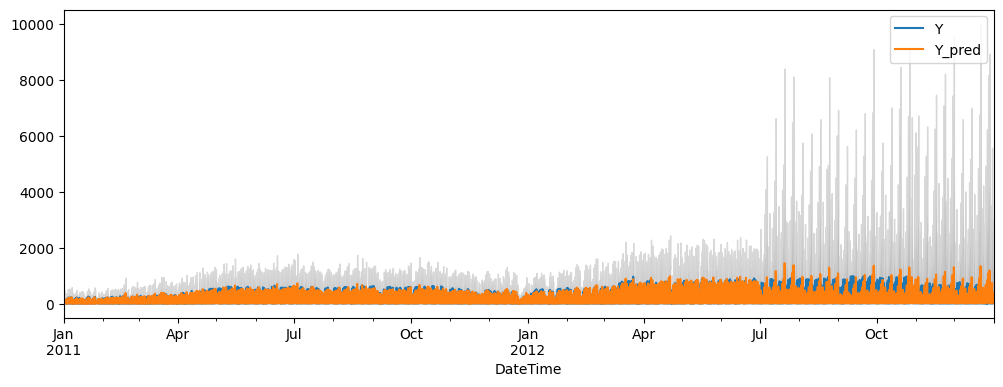

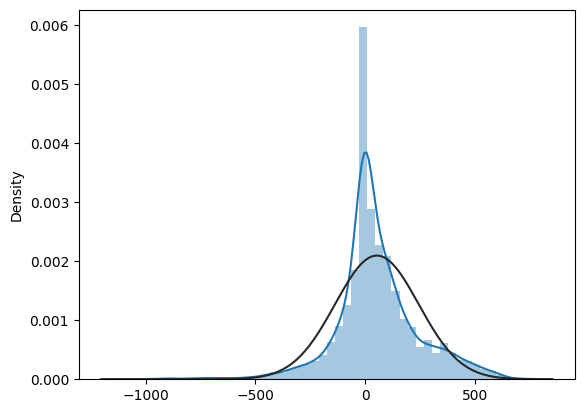

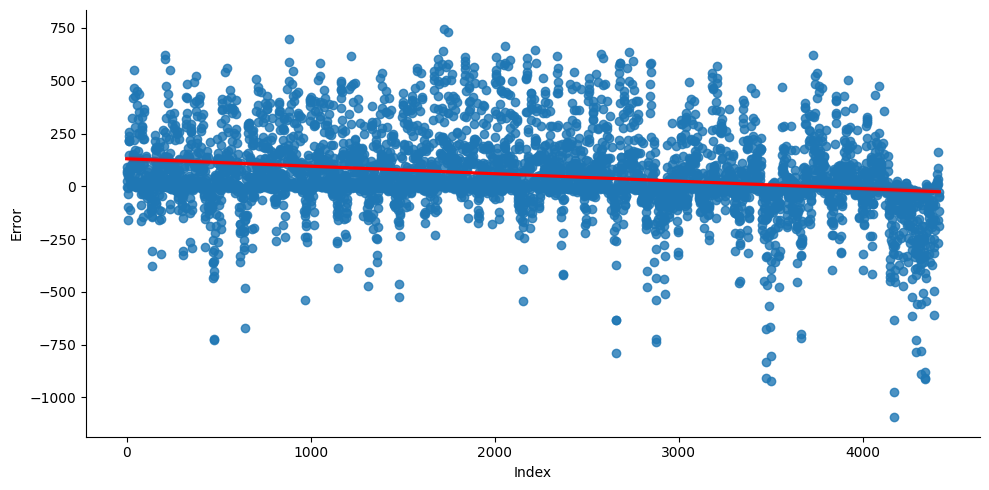

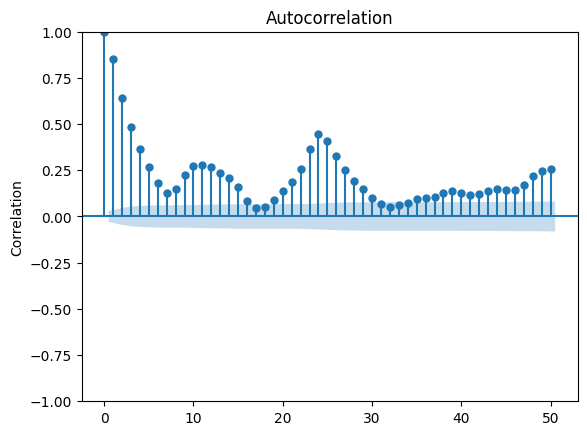

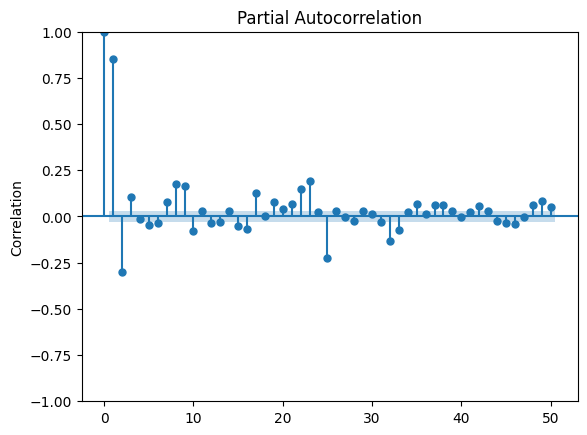

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.94,1.12,"7,825.02","14,784.52",-7.94,2.81
p-value,0.00,0.01,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,32.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [33]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(),
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# 모델링
## Additional Features
exog_tr = X_train_RSM.copy()
exog_te = X_test_RSM.copy()
## Parameter Setting
LOFARITHM = True
TREND_ORDER = (1,0,1)
SEASONAL_ORDER = (1,0,1,24)
pred_start = Y_train.index[0]
pred_end = Y_test.index[-1]
## 비정상 데이터의 정상성 변환
if LOFARITHM:
    Y_train = np.log(Y_train).copy()
    Y_test = np.log(Y_test).copy()
#########################
## SARIMAX
model_sarimax = SARIMAX(Y_train, exog=exog_tr, trend='c',
                        order=TREND_ORDER,
                        seasonal_order=SEASONAL_ORDER).fit()    # 독립변수 반영
display(model_sarimax)
model_pred = model_sarimax.get_prediction(start=pred_start, end=pred_end, exog=exog_te) # 독립변수 반영
Y_pred = model_pred.predicted_mean
Y_pred_ci = model_pred.conf_int()
## 정상성 데이터의 비정상성 변환
if LOFARITHM:
    Y_train = np.exp(Y_train).copy()
    Y_test = np.exp(Y_test).copy()
    Y_pred = np.exp(Y_pred).copy()
    Y_pred_ci = np.exp(Y_pred_ci).copy()
#########################

# 검증
Y_trindex = [i for i in Y_pred.index if i in Y_train.index]
Y_teindex = [i for i in Y_pred.index if i in Y_test.index]
Y_trpred = pd.DataFrame(Y_pred).loc[Y_trindex]
Y_tepred = pd.DataFrame(Y_pred).loc[Y_teindex]
Score_sarimax = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_sarimax)

# 결과 시각화
ax = pd.DataFrame(pd.concat([Y_train, Y_test], axis=0)).plot(figsize=(12,4))
pd.DataFrame(Y_pred).plot(label='Time Sequence Prediction', ax=ax)
ax.fill_between(Y_pred_ci.index, Y_pred_ci.iloc[:,0], Y_pred_ci.iloc[:,1],
                color='k', alpha=0.15)
plt.legend(['Y', 'Y_pred'])
plt.show()

# 에러 분석
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)


# **Advanced Algorithm:** AutoARIMA

## AutoARIMA 모듈 사용

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12
Performing stepwise search to minimize bic
 ARIMA(1,0,1)(1,0,1)[24] intercept   : BIC=146012.025, Time=18.46 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : BIC=170651.417, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : BIC=147706.695, Time=13.70 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : BIC=158124.767, Time=16.14 sec
 ARIMA(0,0,0)(0,0,0)[24]             : BIC=180186.987, Time=0.10 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : BIC=147197.582, Time=15.38 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : BIC=145793.363, Time=21.82 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : BIC=151553.288, Time=1.08 sec
 ARIMA(1,0,1)(2,0,0)[24] intercept   : BIC=146007.580, Time=55.46 sec
 ARIMA(1,0,1)(2,0,1)[24] intercept   : BIC=146291.590, Time=46.62 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : BIC=158303.293, Time=20.48 sec
 ARIMA(0,0,0)(1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                13128
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 24)   Log Likelihood              -72872.975
Date:                             Thu, 04 May 2023   AIC                         145755.951
Time:                                     00:07:00   BIC                         145793.363
Sample:                                 01-01-2011   HQIC                        145768.445
                                      - 06-30-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     29.8922      2.191     13.642      0.000      25.597      34.187
ar.L1          0.4303      0.010     42.805      0.000       0.411       0.450
ma.L1          0.5458      0.013     42.837      0.000       0.521       0.571
ar.S.L24       0.7343      0.008     94.569      0.000       0.719       0.750
sigma2      5929.2048     70.897     83.631      0.000    5790.249    6068.161
===================================================================================
Ljung-Box (L1) (Q):                  64.60   Jarque-Bera (JB):             20962.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.28   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,MAE,MSE,MAPE
Train,39.41,"3,413.71",1.25
Test,172.58,"50,780.58",5.08


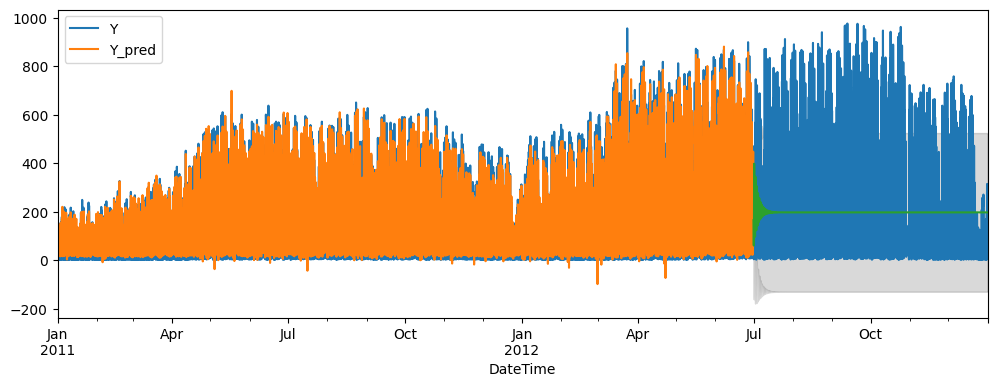

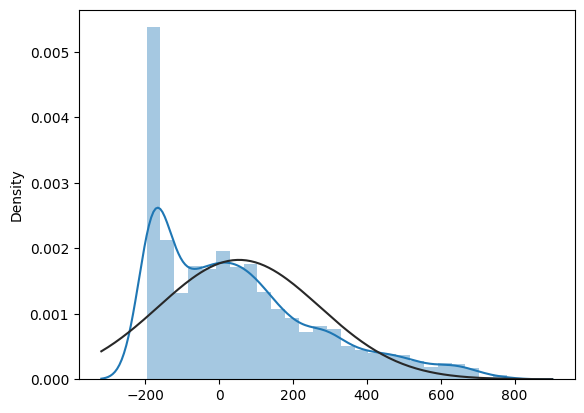

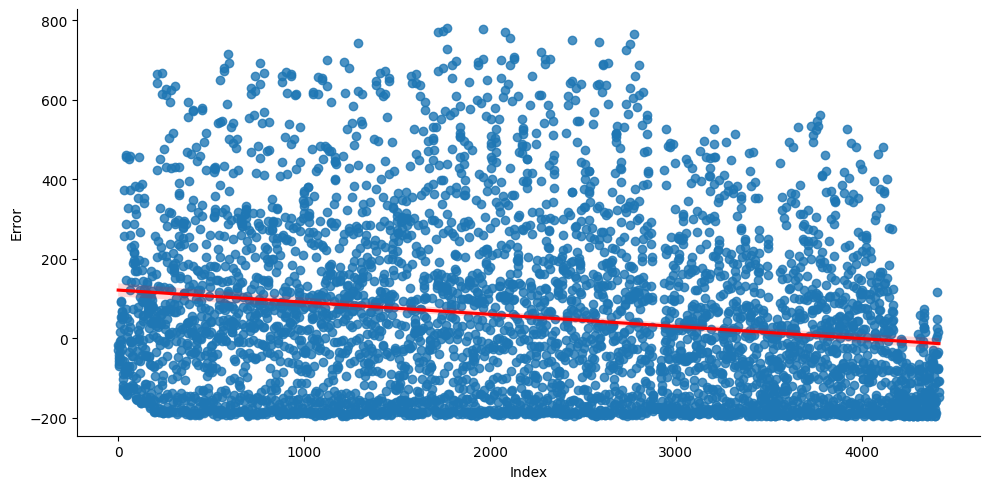

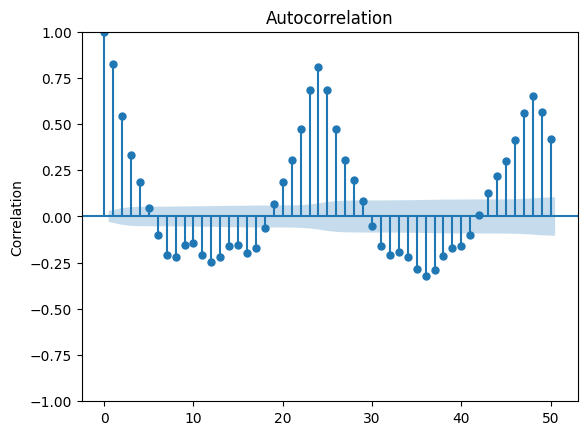

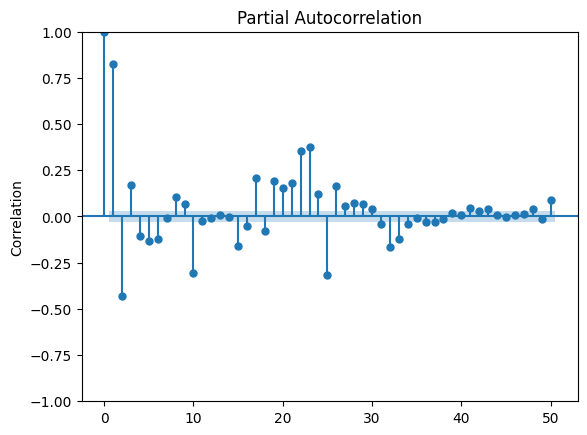

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.91,0.00,"5,596.70","26,445.89",-4.34,6.41
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,23.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [34]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(),
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# 모델링
## Auto-ARIMA
model_autoarima = AutoARIMA(stationaty=False,
                            seasonal=True,
                            with_intercept='auto',
                            start_p=1, max_p=1,
                            start_q=1, max_q=1,
                            max_d=1,
                            max_P=2, max_Q=2,
                            max_D=1,
                            m=24,
                            max_order=50, maxiter=5,
                            test='adf',
                            information_criterion='bic',
                            n_jobs=-1,
                            trace=True)
model_autoarima.fit(Y_train)
display(model_autoarima.summary())
Y_trpred = model_autoarima.predict_in_sample(return_conf_int=False)
Y_trpred = pd.DataFrame(Y_trpred, index=Y_train.index)
Y_tepred, Y_pred_ci = model_autoarima.predict(n_periods=Y_test.shape[0], return_conf_int=True)
Y_tepred = pd.DataFrame(Y_tepred, index=Y_test.index, columns=['Y_tepred'])
Y_pred_ci = pd.DataFrame(Y_pred_ci, index=Y_test.index, columns=['lower', 'upper'])

# 검증
Score_autoarima = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_autoarima)

# 결과 시각화
ax = pd.DataFrame(pd.concat([Y_train, Y_test], axis=0)).plot(figsize=(12,4))
pd.concat([Y_trpred.rename(columns={'prediction_mean':'Y_pred'}),
           Y_tepred.rename(columns={'Y_tepred':'Y_pred'})], axis=0).plot(label='Time Sequence Prediction', ax=ax)
ax.fill_between(Y_pred_ci.index, Y_pred_ci.iloc[:,0], Y_pred_ci.iloc[:,1],
                color='k', alpha=0.15)
plt.legend(['Y', 'Y_pred'])
plt.show()

# 에러 분석
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

## SARIMAX 모수 반복

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


  0%|          | 0/4 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51188D-01    |proj g|=  4.44896D-01


 This problem is unconstrained.



At iterate    5    f=  8.21816D-01    |proj g|=  4.95442D-02

At iterate   10    f=  7.53492D-01    |proj g|=  1.56064D+00

At iterate   15    f=  7.29130D-01    |proj g|=  3.32949D-01

At iterate   20    f=  7.24316D-01    |proj g|=  3.57606D-02

At iterate   25    f=  7.24133D-01    |proj g|=  2.07460D-01

At iterate   30    f=  7.23545D-01    |proj g|=  1.35864D+00

At iterate   35    f=  7.17227D-01    |proj g|=  1.11809D+00

At iterate   40    f=  6.60288D-01    |proj g|=  2.92566D-01

At iterate   45    f=  6.46003D-01    |proj g|=  5.28183D-02

At iterate   50    f=  6.45500D-01    |proj g|=  8.40105D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53013D-01    |proj g|=  4.39157D-01

At iterate    5    f=  8.20679D-01    |proj g|=  1.98897D-02

At iterate   10    f=  7.49965D-01    |proj g|=  1.43571D+00

At iterate   15    f=  7.23536D-01    |proj g|=  1.03865D+00

At iterate   20    f=  7.21292D-01    |proj g|=  4.34181D-01

At iterate   25    f=  6.93474D-01    |proj g|=  4.39674D-01

At iterate   30    f=  6.89118D-01    |proj g|=  3.82841D-01

At iterate   35    f=  6.71353D-01    |proj g|=  9.85058D-01

At iterate   40    f=  6.42973D-01    |proj g|=  6.86940D-02

At iterate   45    f=  6.31137D-01    |proj g|=  1.04889D+00

At iterate   50    f=  6.28946D-01    |proj g|=  2.56121D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.19801D-01    |proj g|=  1.36888D-02

At iterate   10    f=  6.99641D-01    |proj g|=  4.41756D-01

At iterate   15    f=  6.85099D-01    |proj g|=  5.74567D-02

At iterate   20    f=  6.68479D-01    |proj g|=  1.68549D-01

At iterate   25    f=  6.52702D-01    |proj g|=  3.59728D-01

At iterate   30    f=  6.49148D-01    |proj g|=  2.40084D-02

At iterate   35    f=  6.49085D-01    |proj g|=  7.45626D-02

At iterate   40    f=  6.48492D-01    |proj g|=  2.85740D-02

At iterate   45    f=  6.46933D-01    |proj g|=  2.04012D-01

At iterate   50    f=  6.45930D-01    |proj g|=  2.59792D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.14515D-01    |proj g|=  4.56636D-02

At iterate   10    f=  7.41116D-01    |proj g|=  1.56795D+00

At iterate   15    f=  7.18207D-01    |proj g|=  2.44787D-01

At iterate   20    f=  7.05305D-01    |proj g|=  5.62155D+00

At iterate   25    f=  6.93342D-01    |proj g|=  1.63973D+01

At iterate   30    f=  6.89251D-01    |proj g|=  3.84856D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     31     60      1     0     0   3.849D+01   6.893D-01
  F =  0.68925057997164807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 25%|██▌       | 1/4 [42:20<2:07:00, 2540.02s/it]

Fit SARIMAX: trend_order=(1, 0, 1), seasonal_order=(2, 0, 2, 24) AIC=18136.963227735592, BIC=18286.61328039099
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48653D-01    |proj g|=  4.40258D-01


 This problem is unconstrained.



At iterate    5    f=  8.16268D-01    |proj g|=  4.44793D-02

At iterate   10    f=  7.63303D-01    |proj g|=  3.59240D-01

At iterate   15    f=  7.45787D-01    |proj g|=  2.45092D-01

At iterate   20    f=  7.45187D-01    |proj g|=  3.03801D-01

At iterate   25    f=  7.42175D-01    |proj g|=  3.52413D+00

At iterate   30    f=  7.38351D-01    |proj g|=  1.20694D+00

At iterate   35    f=  7.37163D-01    |proj g|=  2.11185D-01

At iterate   40    f=  7.36293D-01    |proj g|=  1.66489D+00

At iterate   45    f=  6.98713D-01    |proj g|=  1.64919D+00

At iterate   50    f=  6.85675D-01    |proj g|=  1.00617D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.18392D-01    |proj g|=  2.19642D-02

At iterate   10    f=  7.67573D-01    |proj g|=  1.14294D-01

At iterate   15    f=  7.40768D-01    |proj g|=  9.77380D-02

At iterate   20    f=  7.00082D-01    |proj g|=  2.24124D+00

At iterate   25    f=  6.76774D-01    |proj g|=  1.51592D+00

At iterate   30    f=  6.76469D-01    |proj g|=  2.96040D-01

At iterate   35    f=  6.75913D-01    |proj g|=  1.80807D-02

At iterate   40    f=  6.75897D-01    |proj g|=  2.17081D-01

At iterate   45    f=  6.73516D-01    |proj g|=  1.05286D+00

At iterate   50    f=  6.72732D-01    |proj g|=  6.07416D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48260D-01    |proj g|=  4.41478D-01

At iterate    5    f=  8.17052D-01    |proj g|=  1.40005D-02

At iterate   10    f=  7.65932D-01    |proj g|=  7.95912D-01

At iterate   15    f=  7.49263D-01    |proj g|=  2.67026D-01

At iterate   20    f=  7.00445D-01    |proj g|=  7.93012D-01

At iterate   25    f=  6.97270D-01    |proj g|=  3.85169D-02

At iterate   30    f=  6.84983D-01    |proj g|=  3.10802D-01

At iterate   35    f=  6.83010D-01    |proj g|=  1.64518D-02

At iterate   40    f=  6.82586D-01    |proj g|=  1.51572D-01

At iterate   45    f=  6.67563D-01    |proj g|=  1.38920D-01

At iterate   50    f=  6.43377D-01    |proj g|=  5.97825D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48951D-01    |proj g|=  4.39189D-01

At iterate    5    f=  8.11587D-01    |proj g|=  5.41542D-02

At iterate   10    f=  7.56783D-01    |proj g|=  2.94385D-01

At iterate   15    f=  7.13784D-01    |proj g|=  2.02043D-01

At iterate   20    f=  7.07396D-01    |proj g|=  2.09848D+00

At iterate   25    f=  7.05940D-01    |proj g|=  2.52374D-01

At iterate   30    f=  7.04042D-01    |proj g|=  1.12680D+01

At iterate   35    f=  6.84060D-01    |proj g|=  1.42296D+01

At iterate   40    f=  6.75109D-01    |proj g|=  4.37944D+01

At iterate   45    f=  6.73954D-01    |proj g|=  1.29205D+00

At iterate   50    f=  6.72866D-01    |proj g|=  9.21421D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 50%|█████     | 2/4 [1:31:15<1:32:24, 2772.47s/it]

Fit SARIMAX: trend_order=(1, 0, 2), seasonal_order=(2, 0, 2, 24) AIC=17708.769323478704, BIC=17865.901878766872


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54993D-01    |proj g|=  4.22195D-01

At iterate    5    f=  8.24972D-01    |proj g|=  2.85446D-02

At iterate   10    f=  8.02839D-01    |proj g|=  1.07591D-01

At iterate   15    f=  7.22773D-01    |proj g|=  9.99010D-01

At iterate   20    f=  6.84081D-01    |proj g|=  1.00393D-01

At iterate   25    f=  6.76200D-01    |proj g|=  3.05511D-02

At iterate   30    f=  6.50894D-01    |proj g|=  8.80450D-01

At iterate   35    f=  6.32985D-01    |proj g|=  2.56937D-01

At iterate   40    f=  6.32623D-01    |proj g|=  4.46704D-01

At iterate   45    f=  6.32460D-01    |proj g|=  2.20400D-02

At iterate   50    f=  6.32412D-01    |proj g|=  1.37427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.22802D-01    |proj g|=  3.14106D-02

At iterate   10    f=  7.98812D-01    |proj g|=  1.02089D-01

At iterate   15    f=  7.12275D-01    |proj g|=  1.56736D-01

At iterate   20    f=  6.56955D-01    |proj g|=  5.04828D+00

At iterate   25    f=  6.50624D-01    |proj g|=  9.00724D-02

At iterate   30    f=  6.44216D-01    |proj g|=  4.17325D+00

At iterate   35    f=  6.39574D-01    |proj g|=  8.09032D-02

At iterate   40    f=  6.36678D-01    |proj g|=  5.31729D-02

At iterate   45    f=  6.36659D-01    |proj g|=  2.17623D-01

At iterate   50    f=  6.34893D-01    |proj g|=  2.19478D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.21681D-01    |proj g|=  3.80470D-02

At iterate   10    f=  8.15706D-01    |proj g|=  3.44377D-02

At iterate   15    f=  7.38064D-01    |proj g|=  1.14482D+00

At iterate   20    f=  7.03079D-01    |proj g|=  2.90631D-01

At iterate   25    f=  6.67403D-01    |proj g|=  2.25434D-01

At iterate   30    f=  6.66778D-01    |proj g|=  8.15729D-02

At iterate   35    f=  6.64684D-01    |proj g|=  2.91004D-02

At iterate   40    f=  6.64510D-01    |proj g|=  8.93192D-03

At iterate   45    f=  6.61130D-01    |proj g|=  3.67033D-01

At iterate   50    f=  6.53972D-01    |proj g|=  3.32291D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56805D-01    |proj g|=  4.86866D-01

At iterate    5    f=  8.17260D-01    |proj g|=  3.94712D-02

At iterate   10    f=  7.62237D-01    |proj g|=  1.83855D-01

At iterate   15    f=  7.36612D-01    |proj g|=  8.78462D-01

At iterate   20    f=  7.20724D-01    |proj g|=  6.11843D-01

At iterate   25    f=  7.18364D-01    |proj g|=  2.60161D-01

At iterate   30    f=  6.93394D-01    |proj g|=  1.82258D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  6.93325D-01    |proj g|=  6.76040D-01

At iterate   40    f=  6.92497D-01    |proj g|=  3.43250D+00

At iterate   45    f=  6.92216D-01    |proj g|=  1.58371D-01

At iterate   50    f=  6.91342D-01    |proj g|=  1.70046D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     77      2     0     0   1.700D+00   6.913D-01
  F =  0.69134183439970254     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 75%|███████▌  | 3/4 [2:13:41<44:29, 2669.23s/it]  

Fit SARIMAX: trend_order=(2, 0, 1), seasonal_order=(2, 0, 2, 24) AIC=18193.87120399859, BIC=18351.00375928676


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47581D-01    |proj g|=  4.42658D-01

At iterate    5    f=  8.16724D-01    |proj g|=  6.91451D-02

At iterate   10    f=  7.53931D-01    |proj g|=  4.44455D-01

At iterate   15    f=  7.39149D-01    |proj g|=  1.88103D-01

At iterate   20    f=  7.06975D-01    |proj g|=  9.32839D-01

At iterate   25    f=  7.00691D-01    |proj g|=  5.72507D-02

At iterate   30    f=  6.81894D-01    |proj g|=  1.19686D-01

At iterate   35    f=  6.54496D-01    |proj g|=  1.11712D+00

At iterate   40    f=  6.52906D-01    |proj g|=  8.17644D-01

At iterate   45    f=  6.20885D-01    |proj g|=  6.39137D+00

At iterate   50    f=  6.13325D-01    |proj g|=  9.41846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49543D-01    |proj g|=  4.36470D-01

At iterate    5    f=  8.17126D-01    |proj g|=  2.15129D-02

At iterate   10    f=  7.66318D-01    |proj g|=  9.08575D-01

At iterate   15    f=  7.25242D-01    |proj g|=  1.09175D-01

At iterate   20    f=  6.74410D-01    |proj g|=  6.26168D+00

At iterate   25    f=  6.62023D-01    |proj g|=  6.39561D-01

At iterate   30    f=  6.41422D-01    |proj g|=  1.04484D+00

At iterate   35    f=  6.39715D-01    |proj g|=  5.51428D-02

At iterate   40    f=  6.38076D-01    |proj g|=  3.73616D-01

At iterate   45    f=  6.36235D-01    |proj g|=  9.89118D-02

At iterate   50    f=  6.35865D-01    |proj g|=  5.49817D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47183D-01    |proj g|=  4.43892D-01

At iterate    5    f=  8.15670D-01    |proj g|=  1.42720D-02

At iterate   10    f=  7.43089D-01    |proj g|=  2.47827D+00

At iterate   15    f=  6.73535D-01    |proj g|=  4.54956D-01

At iterate   20    f=  6.51878D-01    |proj g|=  8.07972D-02

At iterate   25    f=  6.46619D-01    |proj g|=  2.35731D-01

At iterate   30    f=  6.42560D-01    |proj g|=  1.41576D-01

At iterate   35    f=  6.41653D-01    |proj g|=  5.64038D-02

At iterate   40    f=  6.40410D-01    |proj g|=  3.78483D-01

At iterate   45    f=  6.38180D-01    |proj g|=  3.53947D-01

At iterate   50    f=  6.36805D-01    |proj g|=  1.07895D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47948D-01    |proj g|=  4.41378D-01

At iterate    5    f=  8.10457D-01    |proj g|=  4.72826D-02

At iterate   10    f=  7.33345D-01    |proj g|=  7.43551D-01

At iterate   15    f=  6.97253D-01    |proj g|=  1.07115D+00

At iterate   20    f=  6.88487D-01    |proj g|=  9.53616D+00

At iterate   25    f=  6.88214D-01    |proj g|=  3.49703D+00

At iterate   30    f=  6.88164D-01    |proj g|=  3.85483D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     34    102      2     0     0   4.744D+00   6.881D-01
  F =  0.68814552053420297     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
100%|██████████| 4/4 [3:09:15<00:00, 2838.87s/it]

Fit SARIMAX: trend_order=(2, 0, 2), seasonal_order=(2, 0, 2, 24) AIC=18111.948787146033, BIC=18276.563845066972
The smallest BIC is 16293.10293086641 for model SARIMAX(2, 0, 2)x(1, 0, 1, 24)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47581D-01    |proj g|=  4.42658D-01


 This problem is unconstrained.



At iterate    5    f=  8.16724D-01    |proj g|=  6.91451D-02

At iterate   10    f=  7.53931D-01    |proj g|=  4.44455D-01

At iterate   15    f=  7.39149D-01    |proj g|=  1.88103D-01

At iterate   20    f=  7.06975D-01    |proj g|=  9.32839D-01

At iterate   25    f=  7.00691D-01    |proj g|=  5.72507D-02

At iterate   30    f=  6.81894D-01    |proj g|=  1.19686D-01

At iterate   35    f=  6.54496D-01    |proj g|=  1.11712D+00

At iterate   40    f=  6.52906D-01    |proj g|=  8.17644D-01

At iterate   45    f=  6.20885D-01    |proj g|=  6.39137D+00

At iterate   50    f=  6.13325D-01    |proj g|=  9.41846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                count   No. Observations:                13128
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 24)   Log Likelihood               -8051.726
Date:                              Thu, 04 May 2023   AIC                          16143.453
Time:                                      03:38:12   BIC                          16293.103
Sample:                                  01-01-2011   HQIC                         16193.431
                                       - 06-30-2012                                         
Covariance Type:                                opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0004      0.000      2.845      0.004       0.000       0.001
count_diff          1.7003      0.166     10.274      0.000       1.376       2.025
holiday          3079.3797    120.364     25.584      0.000    2843.471    3315.288
count_seasonal      9.2200      0.899     10.252      0.000       7.457      10.983
Day                36.1469      3.283     11.010      0.000      29.712      42.582
windspeed          15.4489      1.402     11.017      0.000      12.700      18.197
Quarter_ver2      360.4580     81.292      4.434      0.000     201.128     519.788
Hour              101.3212      7.195     14.083      0.000      87.220     115.423
weather           212.3468     17.190     12.353      0.000     178.654     246.039
Quarter_Dummt_2   566.1909    124.261      4.556      0.000     322.644     809.738
DayofWeek         645.8028     15.806     40.859      0.000     614.824     676.781
workingday       2676.1237     51.555     51.908      0.000    2575.078    2777.169
count_lag2          0.3603      0.233      1.549      0.121      -0.096       0.816
ar.L1               1.0942      0.029     37.520      0.000       1.037       1.151
ar.L2              -0.3610      0.023    -15.644      0.000      -0.406      -0.316
ma.L1              -0.1567      0.029     -5.344      0.000      -0.214      -0.099
ma.L2               0.2452      0.010     24.118      0.000       0.225       0.265
ar.S.L24            0.9975      0.000   2867.715      0.000       0.997       0.998
ma.S.L24           -0.9622      0.002   -458.321      0.000      -0.966      -0.958
sigma2              0.1990      0.002    121.188      0.000       0.196       0.202
===================================================================================
Ljung-Box (L1) (Q):                   2.50   Jarque-Bera (JB):             12999.90
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.48
Prob(H) (two-sided):                  0.32   Kurtosis:                         7.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,MAE,MSE,MAPE
Train,32.07,"2,762.61",0.37
Test,132.58,"38,956.92",0.98


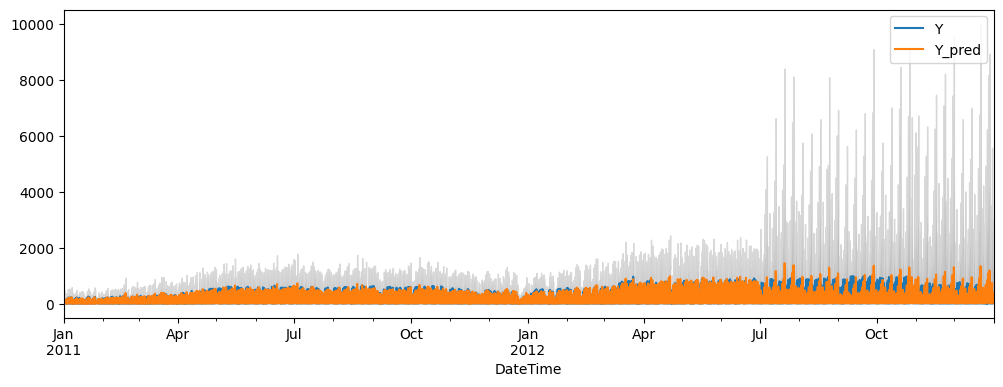

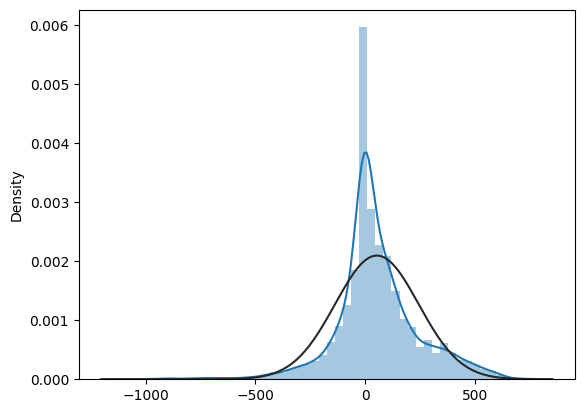

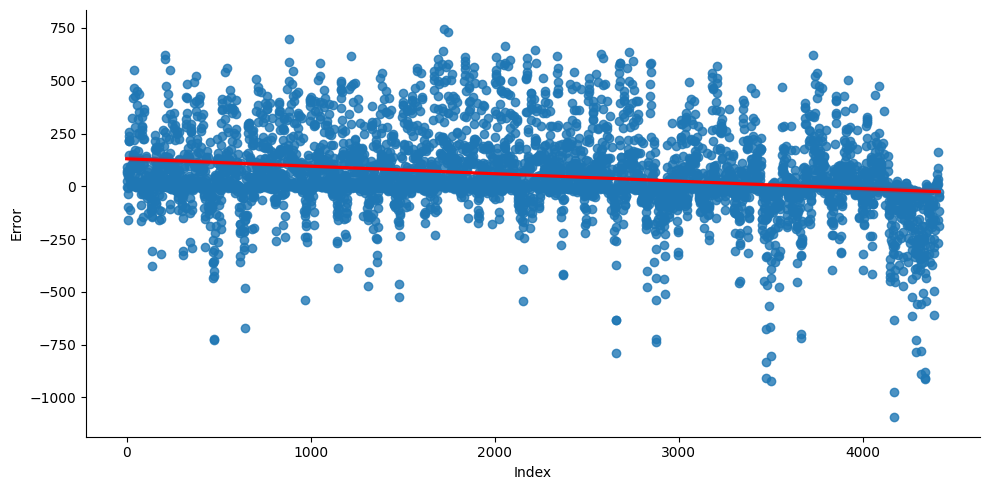

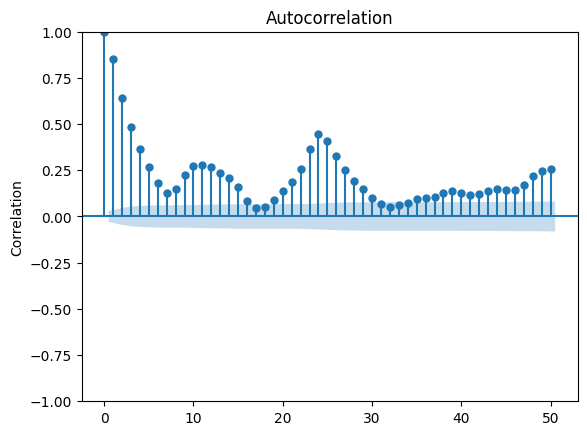

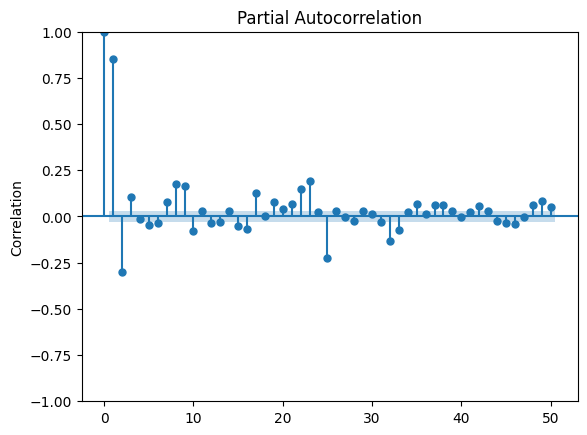

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.94,1.12,"7,825.02","14,784.52",-7.94,2.81
p-value,0.00,0.01,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,32.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [36]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(),
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# 모델링
## Additional Features
exog_tr = X_train_RSM.copy()
exog_te = X_test_RSM.copy()
## Parameter Setting
LOGARITHM = True
p, d, q = range(1, 3), range(0, 1), range(1, 3)
P, D, Q = range(1, 3), range(0, 1), range(1, 3)
TREND_PDQ = list(product(p, d, q))
SEASONAL_PDQ = [(candi[0], candi[1], candi[2], 24) 
                for candi in list(product(P, D, Q))]
pred_start = Y_train.index[0]
pred_end = Y_test.index[-1]
## 비정상성 데이터의 정상성 변환
if LOGARITHM:
    Y_train = np.log(Y_train)
    Y_test = np.log(Y_test)
##########################
## SARIMAX
BIC = []
SARIMAX_order = []
for TREND_ORDER in tqdm(TREND_PDQ):
    for SEASONAL_ORDER in SEASONAL_PDQ:
        try:
            result = SARIMAX(Y_train, trend='c',
                             order=TREND_ORDER,
                             seasonal_order=SEASONAL_ORDER,
                             exog=exog_tr).fit()
            print('Fit SARIMAX: trend_order={}, seasonal_order={} AIC={}, BIC={}'.format(TREND_ORDER, SEASONAL_ORDER, result.aic, result.bic, end='\r'))
            BIC.append(result.bic)
            SARIMAX_order.append([TREND_ORDER, SEASONAL_ORDER])
        except:
            continue
## Parameter Selection
print('The smallest BIC is {} for model SARIMAX{}x{}'.format(min(BIC), SARIMAX_order[BIC.index(min(BIC))][0], SARIMAX_order[BIC.index(min(BIC))][1]))
## Auto-SARIMAX Fitting
model_autosarimax = SARIMAX(Y_train, trend='c',
                            order=SARIMAX_order[BIC.index(min(BIC))][0],
                            seasonal_order=SARIMAX_order[BIC.index(min(BIC))][1],
                            exog=exog_tr).fit()
display(model_autosarimax.summary())
Y_pred = model_pred.predicted_mean
Y_pred_ci = model_pred.conf_int()
## 정상성 데이터의 비정상성 변환
if LOGARITHM:
    Y_train = np.exp(Y_train)
    Y_test = np.exp(Y_test)
    Y_pred = np.exp(Y_pred)
    Y_pred_ci = np.exp(Y_pred_ci)
##########################

# 검증
Y_trindex = [i for i in Y_pred.index if i in Y_train.index]
Y_teindex = [i for i in Y_pred.index if i in Y_test.index]
Y_trpred = pd.DataFrame(Y_pred).loc[Y_trindex]
Y_tepred = pd.DataFrame(Y_pred).loc[Y_teindex]
Score_sarima = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_sarima)

# 결과 시각화
ax = pd.DataFrame(pd.concat([Y_train, Y_test], axis=0)).plot(figsize=(12,4))
pd.DataFrame(Y_pred).plot(label='Time Sequence Prediction', ax=ax)
ax.fill_between(Y_pred_ci.index, Y_pred_ci.iloc[:,0], Y_pred_ci.iloc[:,1],
                color='k', alpha=0.15)
plt.legend(['Y', 'Y_pred'])
plt.show()

# 에러 분석
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)